

# **Practica 1.b: Técnicas de Búsqueda Local y Algoritmos Greedy para el Problema del Aprendizaje de Pesos en Características**
## *Pablo Millan Cubero*


El problema del aprendizaje de pesos en características parte del aprendizaje supervisado, donde tenemos un conjunto de datos en los que para cada elemento se tienen N características por cada individuo y la clase a la que este pertenece.<br>
<br>\begin{align}
        C_n = (x_1, w_2, ..., x_n)
    \end{align}
<br>Nuestro objetivo es predecir la clase de nuevos individuos fuera del conjunto a partir de sus características. Esto lo hacemos en dos fases: aprendizaje, donde extraemos información de un conjunto de datos para aprender de él y validación, donde comprobamos cómo de bien funciona nuestro modelo para datos nuevos

<br>En nuestro caso usaremos el *clasificador 1-NN*. Partimos de un dataset del que disponemos de las clases. Si tenemos un elemento nuevo E al que queremos obtener su clase, calculamos la distancia euclidea de E al resto de elementos y le asignamos la clase del vecino con menor distancia.

<br>El Aprendizaje de Pesos en Características (APC) es un problema que optimiza el rendimiento de 1-NN ponderando la importancia de cada atributo a la hora de calcular la distancia. Para ello usamos un vector w:<br>

<br>\begin{align}
        w = (w_1, w_2, ..., w_n), w_i\in[0, 1]
    \end{align}

<br>Nuestro objetivo será encontrar los valores para cada $w_i$ que nos proporcionen un mejor resultado.

Antes de proceder con los siguientes apartados, ya que contendrán código vamos a declarar aquí los imports de librerías y función para cargar los ficheros.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import KFold
from google.colab import drive
drive.mount('/content/drive')
import time
from scipy.io import arff

Mounted at /content/drive


Para cargar los datos de los ficheros arrf he usado un módulo de la librería de scipy. Con la función que trae puedo cargar el dataset completo en estructuras de datos de Numpy. He recorrido esas estructuras con bucles para traducirlas a dos arrays: uno con los atributos y otro con las clases. El array de clases concretamente es un array de chars, ya que en uno de los datasets las clases se indican por letras y no por números, y como no necesitamos hacer operaciones con estos más allá de comparaciones, con chars nos valdrá.<br>

Los datos se separan en clases y atributos por razones de optimización. Las funciones que nos brinda Numpy para operar sobre matrices se usan mucho más facilmente si tenemos una matriz limpia con los datos a operar y sin las etiquetas.

In [ ]:
def cargar_datos(nombre):

  data = arff.loadarff(nombre)
  datos = np.zeros((len(data[0]), len(data[0][0])-1))

  #Cargamos datos
  for i in range(0, len(datos)):
    for j in range(0, len(datos[0])):
      datos[i][j] = data[0][i][j]

  #Cargamos los atributos
  clases = np.chararray(len(datos))
  n_atrib = len(datos[0])
  for i in range (0, len(datos)):
    clases[i] = data[0][i][n_atrib]

  return datos, clases

Para representar los datasets he escogido como estructura de datos los arrays de Numpy. Dado a que nos permiten ejecutar código en C, mucho más rápido que el de Python, acelerará mucho las ejecuciones.<br>

Los atributos se almacenarán en una matriz de dimensión $(i, j)$, donde $i$ representa cada elemento y $j$ cada atributo. Se almacena aparte un array de una única dimensión $i$ que contiene la clase de cada elemento. Este último es concretamente un array de chars.<br>

Las soluciones se representarán en un array $w$ de dimensión $j$, donde cada elemento será un número real entre [0, 1].

Para no dar más importancia a los atributos cuyos valores tengan una mayor magnitud que otros se normalizarán los datos al intervalo [0, 1] con este pseudocódigo:


```
>Entrada:datos

min = Vector, cada elemento j contiene el MINIMO valor de la columna j en los datos
max = Vector, cada elemento j contiene el MAXIMO valor de la columna j en los datos

datos[n] = (datos[n] - min[n]) / (max[n]  - min[n])

return datos
```

Este último código se ve reflejado en las funciones *max_min_values(datos)* que devuelve 2 vectores con los máximos y minimos elementos de cada columna, y *normaliza(datos, min, dif)*, que hace la actualización del dataset. Los datos deberán ser normalizados antes de ser procesados por cualquier algoritmo ya que de no ser así obtendremos resultados engañosos.<br>


In [ ]:
#Calcula el minimo y maximo para cada atributo de un conjunto de datos
def max_min_values(datos):
  max = np.zeros(len(datos[0]))
  min = np.zeros(len(datos[0]))

  min = np.apply_along_axis(np.amin, 0, datos)
  max = np.apply_along_axis(np.amax, 0, datos)

  return min, max

#Normaliza un set de datos dado el vector de minimos y el vector max-min
def normaliza(datos, min, dif):
  ret = (datos - min)/dif
  ret[np.isnan(ret)] = 0
  return ret

<br>Para evaluar la calidad de una solución empleamos:

<br>\begin{align}
        tasa\_clas = 100⋅\frac{nº\: instancias\: bien\: clasificadas}{nº\: instancias}
    \end{align}

<br>\begin{align}
        tasa\_red = 100⋅\frac{nº\: valores\: w_i < 0.1}{nº\: caracteristicas}
    \end{align}

Tendremos la siguiente agregación:

<br>\begin{align}
        F(W) = \alpha⋅tasa\_clas(W)+(1-\alpha)⋅tasa\_red(W)
    \end{align}

In [ ]:
#Calcular el fitness
def evaluacion(w, alpha, error):
  return alpha*error + (1 - alpha)*( len(w[w < 0.1])/len(w) )

En esta práctica tendremos en compararemos la clasificación de los conjuntos dada por:



<br>1.   Clasificador 1-NN: La base desde que partimos. Como ya se ha explicado, calculamos la distancia euclídea de un elemento al resto y elegimos la clase del vecino de menor distancia. Para este caso se tendrá en cuenta un vector $w$ con todos sus elementos inicializados a 1, para no dar preferencia a un atributo sobre otro. Su salida es un fitness de un conjunto de datos sobre el que se aplica.<br>

<br>2.   Algoritmo RELIEF: Este algoritmo tiene como entrada un conjunto de datos con sus clases. Parte de un vector de pesos inicializado a 0, realiza N iteraciones (siendo N el tamaño del conjunto de datos) en los que se calcula los vecino (elemento de la misma clase) y enemigo (elemento de diferente clase) más cercanos y actualiza $w$ con la diferencia entre estos dos. Es determinístico y como salida obtenemos el vector de pesos $w$ ajustado, y por tanto de forma implícita el fitness para el conjunto de entrenamiento.

<br>3. Algoritmo de Búsqueda Local: Tenemos como entrada un conjunto de datos con sus clases y un número máximo de iteraciones. Se inicializa $w$ con números aleatorios de [0, 1]. Por cada iteración, se calculará un vecino para el $w$ actual y se evaluará la agregación que se obtiene con ese vecino. Si conseguimos una agregación mejor, actualizamos nuestro valor $w$ con el nuevo. Si llegamos al límite de iteraciones totales o el límite de iteraciones sin obtener una mejora, dejamos de buscar. Su salida es el vector de pesos $w$ ajustado, y de forma implícita el fitness.

Ahora veamos el clasificador 1-NN, el que empleamos para la predicción de clases. Este recibe de entrada un conjunto de datos y un conjunto de tests y devuelve el índice del elemento con el que tiene menor distancia. Así se obtiene implicitamente la clase del nuevo elemento.
```
>Entrada:datos, test, w

indices_vecino = [nº datos]

  distancias = [test.size][nº atributos]
  for ejemplo in test:
    distancia[ejemplo] = (datos - ejemplo)^2
    distancia[ejemplo] = suma_de_filas(distancia[ejemplo])
    distancia[ejemplo] = raiz_cuadrada(distancias[ejemplo])

return index(valor_minimo(distancia))

```
Este trabajo se divide entre las funciones *alg_1NN(datos, test, w, max_values, min_values)*, que es el cuerpo principal del pseudocódigo, *classf_1NN(nuevo, datos, w)*, que calcula el índice del vecino más cercano para un solo elemento y *dist_1NN(nuevo, datos, w)* que devuelve un vector de distancias con cada elemento del dataset para un único elemento.<br>

Aquí reside el alma de todos los algoritmos, por así decirlo. El tiempo de ejecución es muy dependiente de estas funciones, ya que aquí es donde se van a hacer todos los cálculos. Es por ello que he puesto bastante atención en optimizarla. Todas las operaciones se hacen sobre matrices y no sobre datos sueltos, que gracias a Numpy ejecutamos en código C. Esto nos reduce muchísimo el tiempo de ejecución qu esi lo hiciéramos con bucles anidados.


In [ ]:
#Similar a la función anterior pero devuelve el vector distancias
def dist_1NN(nuevo, datos, w):
  distancias = (datos-nuevo)**2*w
  distancias = np.sum(distancias, 1)
  distancias = np.sqrt(distancias)
  return distancias

#Devuelve la predicción de clase del ejemplo 'nuevo'
def classf_1NN(nuevo, datos, w):
  distancias = dist_1NN(nuevo, datos, w)
  return np.where(distancias == np.amin(distancias))[0][0]

#Ejecuta el classificador 1-NN para un ejemplo de datos y de test
  #devuelve el indice del más cercano a cada uno
def alg_1NN(datos, test, w, max_values, min_values):

  dif = max_values - min_values
  test = (test - min_values)/dif
  datos = normaliza(datos, min_values, dif)

  index_clases = np.zeros(len(test))
  for i in range(0, len(test)):
    index_clases[i] = classf_1NN(test[i], datos, w)

  return index_clases

Contamos con dos funciones distintas para calcular el número de fallos en las predicciones del algoritmo 1-NN para unos datos y unos pesos determinados por simple conveniencia. Estas son *calcula_error* y *calcula_error_leave*. Lo único en lo que se diferencian es que una calcula el error para un conjunto de test sobre un conjunto de entrenamiento mientras que el otro calcula el error sobre un solo conjunto usando *leave one out*. Aquí el primero de ellos:<br>



```
>Entrada: datos, clases, test, clases_test, w

aciertos = 0
for x in test:
  c = calcular_clase(x, datos, w)
  if (c == clases_test[x])
    aciertos++

return aciertos/test.size
```

In [ ]:
#Calcular error para un conjunto de train y test
def calcular_error(datos, clas_d, test, clas_t, w):
  error = 0.0
  min_val, max_val = max_min_values(datos)
  datos = normaliza(datos, min_val, max_val-min_val)

  min_val, max_val = max_min_values(test)
  test = normaliza(test, min_val, max_val-min_val)

  for i in range(0, len(test)):
    c = classf_1NN(test[i], datos, w)
    if (clas_d[c] == clas_t[i]):
      error += 1

  return error/len(test)


Y aquí la versión leave one out:


```
>Entrada: datos, clases, w

aciertos = 0
for x in datos:
  c = calcular_clase(x, datos[excepto x], w)
  if (c == clases_test[x])
    aciertos++

return aciertos/test.size
```



In [ ]:
#Calcula el error sobre un conjunto (leave one out)
def calcular_error_leave(datos, clases, w):

  aciertos = 0
  for i in range(0, len(datos)):
      w_temp = w.copy()
      w_temp[w_temp < 0.1] = 0
      c = classf_1NN(datos[i], np.delete(datos, i, 0), w_temp)
      if (np.delete(clases, i)[c] == clases[i]):
        aciertos += 1

  return aciertos/len(datos)

##Algoritmo de búsqueda local

El funcionamiento básico del algoritmo fue descrito en apartados anteriores. Aquí detallaremos el pseudocódigo y el operador de mutación para explorar el vecindario.

Para el operador de cálculo de vecino elegiremos un atributo de $w$ al azar (debemos intentar aplicarlo al resto de atributos una vez al menos antes de volver a aplicarlo al mismo) y le sumaremos al atributo un valor obtenido de una distribución normal con media = 0 y varianza = 0.3. Si el nuevo valor está por debajo de 0 o por encima de 1, lo capamos. El código de este operador a continuación. 

```
operador_mutacion(w, i):
  w[i] = N(0, 0.3)
  Si w[i] < 0 -> 0
  Si [wi] > 1 -> 1
return w
```

In [ ]:
#Obtener vecino de w
def operador_mutacion(w, i):
  w_nuevo = w
  w_nuevo[i] += np.random.normal(0, 0.3)
  if (w_nuevo[i] < 0):
    w_nuevo[i] = 0
  if (w_nuevo[i] > 1):
    w_nuevo[i] = 1

  return w_nuevo

Y ahora el algoritmo en si:

```
>Entrada: datos, iteraciones_maximas

w_mejor = inicializar_random(atributos.size)
w = w_mejor
fitness_mejor = 0
iteraciones = 0
contador_vecinos = 0

while (contador_vecinos < w.size()*20 and iteraciones < iteraciones_maximas)

  aciertos = calcular_error(datos, w)
  fitness = evaluacion(w, aciertos)

  if(fitness < fitness_mejor):
    fitness_mejor = fitness
    w_mejor = w
    contador_vecinos = 0
  else:
    contador_vecinos++

  w = operador_mutacion(w9
  iteraciones++

return w_mejor
```

Quizás merezca la pena comentar un aspecto que no se ve reflejado en el pseudocódigo. Para asegurarnos que en cada mutación escogemos aleatoriamente un componente de $w$ y no repetimos hasta completar la iteración, se tiene un array auxiliar *indx_w* que contiene los indices barajados de forma aleatoria al comienzo del algoritmo y cada vez que se encuentra una nueva mejor solución.

In [ ]:
def BL_search(datos, clases, max_iter):

  #Normalizar e inicializar w
  w_mejor = np.random.rand(len(datos[0]))
  w = w_mejor
  min_val, max_val = max_min_values(datos)
  datos = normaliza(datos, min_val, max_val-min_val)

  contador_greedy = 0
  i_w = 0
  iterations = 0
  fitness_actual = 0.0
  indx_w = np.arange(0, len(w))
  np.random.shuffle(indx_w)

  while(contador_greedy < len(w)*20 and iterations < max_iter):

    #Se calcula el fitness para w
    aciertos = calcular_error_leave(datos, clases, w)
    fitness = evaluacion(w, 0.5, aciertos)

    #Actualizar fitness y w si procede
    if (fitness > fitness_actual):
      fitness_actual = fitness
      w_mejor = w
      contador_greedy = 0
      i_w = 0
      np.random.shuffle(indx_w)
    else:
      contador_greedy += 1

    #Se calcula nuevo w + control de indices
    w = operador_mutacion(w, indx_w[i_w])
    iterations += 1
    i_w = (i_w+1)%len(w)

  return w, fitness_actual

##Algoritmo Greedy RELIEF

Pasamos ahora al pseudocódigo del algoritmo de comparación RELIEF.

```
>Entrada: datos

w = inicializa_a_cero()

for i in datos.size:

  distancias = vector_distancias(datos[i], datos, w)

  amigo = calcular_minimo(distancias[ clase == clase[i] ])
  enemigo = calcular_minimo(distancias[ clase != clase[i] ])

  w = w + |datos[i] - enemigo| + |datos[i] - amigo|

return w
```

Comentar que para calcular el conjunto de amigos y enemigos de forma eficiente, lo que hacemos es partir de un vector *c* en el que tenemos la distancia a todos los elementos y copiarlo en 2 vectores nuevos, *c_amigo* y *c_enemigo*. En el primero buscamos todos los índices que coincidan con que son de distinta clase que el elemento actual a comparar y asignamos su distancia a infinito, asegurándonos así de que núnca será elegido al buscar el mínimo. De igual manera hacemos lo mismo en *c_enemigo* pero con los índices que sí son de la misma clase.

In [ ]:
def relief_1NN(datos, clases):

  w = np.zeros(len(datos[0]))

  min_val, max_val = max_min_values(datos)
  datos = normaliza(datos, min_val, max_val-min_val)

  for i in range(0, len(datos)): #optimización posible: calcular una matriz con todas las distancias
    
    #Calculamos el vector de distancias
    c = dist_1NN(datos[i], datos, w)
    c[i] = float(np.inf)

    #Calculamos vector de vecinos y enemigos
    c_amigos = c.copy()
    c_enemigos = c.copy()
    c_amigos[clases != clases[i]] = float(np.inf)
    c_enemigos[clases == clases[i]] = float(np.inf)
    indice_enemigo = int(np.where(c_amigos == np.amin(c_amigos))[0][0])
    indice_amigo = int(np.where(c_enemigos[0] == np.amin(c_enemigos[0]))[0][0])

    enemigo = datos[indice_enemigo]
    amigo = datos[indice_amigo]

    #Actualizamos w
    w = w + abs(datos[i] - enemigo) + abs(datos[i] - amigo)

  #Normalizamos los pesos
  w_max = np.amax(w)
  for i in range(0, len(w)):
    if w[i] > 0:
      w[i] = w[i]/w_max
    else:
      w[i] = 0

  return w

Las siguientes funciones no necesitan de pseudocódigo. Basta con saber que he empleado la clase Kfold de Scikit Learn para el 5-fold cross validation. Cada función lanza los tests y ejecuta sus respectivos algoritmos. De estas ejecuciones se han extraido los datos de la tabla.

In [ ]:
def cross_validation_1NN(datos, clases):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  w = np.ones(len(datos[0]))
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    error = evaluacion(w, 0.5, error)
    t2 = time.time()
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

def cross_validation_RL(datos, clases):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    w = relief_1NN(datos[train_index], clases[train_index])
    t2 = time.time()
    error = calcular_error_leave(datos[train_index], clases[train_index], w)
    error = evaluacion(w, 0.5, error)
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

def cross_validation_BL(datos, clases):
  kf = KFold(n_splits=5)
  kf.get_n_splits(datos)
  KFold(n_splits=5, random_state=None, shuffle=False)
  for train_index, test_index in kf.split(datos):
    t1 = time.time()
    w, error = BL_search(datos[train_index], clases[train_index], 15000)
    t2 = time.time()
    print("Fitness en training: ", np.around(error, 3))
    error = np.around(calcular_error(datos[train_index], clases[train_index], datos[test_index], clases[test_index], w), 3)
    red = np.around(len(w[w < 0.1])/len(w), 3)
    print("Aciertos test: ", error, " Red en test: ", red, " Fitness test: ", error*0.5+red*0.5)
    print("T: ", t2-t1)
    print("---------------")

## Ejecuciones

Aquí puede el profesor realizar las ejecuciones y comprobar los resultados. Para establecer otra semilla solo tiene que cambiar el argumento de la función np.random.seed().

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
print("RELIEF ++++++++++++ IONOSPHERE")
print(cross_validation_RL(datos, clases))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
print("RELIEF ++++++++++++ PARKINSONS")
print(cross_validation_RL(datos, clases))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
print("RELIEF ++++++++++++ SPECTF-HEART")
print(cross_validation_RL(datos, clases))

RELIEF ++++++++++++ IONOSPHERE
Fitness en training:  0.45
Aciertos test:  0.803  Red en test:  0.029  Fitness test:  0.41600000000000004
T:  0.04648566246032715
---------------
Fitness en training:  0.445
Aciertos test:  0.714  Red en test:  0.029  Fitness test:  0.3715
T:  0.03494763374328613
---------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


Fitness en training:  0.452
Aciertos test:  0.8  Red en test:  0.029  Fitness test:  0.41450000000000004
T:  0.03244137763977051
---------------
Fitness en training:  0.444
Aciertos test:  0.9  Red en test:  0.029  Fitness test:  0.4645
T:  0.034464120864868164
---------------
Fitness en training:  0.444
Aciertos test:  0.9  Red en test:  0.029  Fitness test:  0.4645
T:  0.033333539962768555
---------------
None
RELIEF ++++++++++++ PARKINSONS
Fitness en training:  0.417
Aciertos test:  0.821  Red en test:  0.0  Fitness test:  0.4105
T:  0.014497041702270508
---------------
Fitness en training:  0.426
Aciertos test:  0.769  Red en test:  0.0  Fitness test:  0.3845
T:  0.015963077545166016
---------------
Fitness en training:  0.41
Aciertos test:  0.718  Red en test:  0.0  Fitness test:  0.359
T:  0.015466690063476562
---------------
Fitness en training:  0.429
Aciertos test:  0.718  Red en test:  0.0  Fitness test:  0.359
T:  0.012784481048583984
---------------
Fitness en training:  0.

In [ ]:
np.random.seed(100)

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
print("RESULTADOS DE BUSQUEDA LOCAL EN IONOSPHERE")
print(cross_validation_BL(datos, clases))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
print("RESULTADOS DE BUSQUEDA LOCAL EN PARKINSONS")
print(cross_validation_BL(datos, clases))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
print("RESULTADOS DE BUSQUEDA LOCAL EN SPECTF-HEART")
print(cross_validation_BL(datos, clases))

RESULTADOS DE BUSQUEDA LOCAL EN IONOSPHERE


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


KeyboardInterrupt: ignored

In [ ]:
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/ionosphere.arff')
min_val, max_val = max_min_values(datos)
datos = normaliza(datos, min_val, max_val-min_val)

print("RESULTADOS DE 1-NN EN IONOSPHERE")
print(cross_validation_1NN(datos, clases))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
min_val, max_val = max_min_values(datos)
datos = normaliza(datos, min_val, max_val-min_val)

print("RESULTADOS DE 1-NN EN PARKINSONS")
print(cross_validation_1NN(datos, clases))

datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/spectf-heart.arff')
min_val, max_val = max_min_values(datos)
datos = normaliza(datos, min_val, max_val-min_val)

print("RESULTADOS DE 1-NN EN SPECTF-HEART")
print(cross_validation_1NN(datos, clases))

RESULTADOS DE 1-NN EN IONOSPHERE
Aciertos test:  0.3945  Red en test:  0.0  Fitness test:  0.19725
T:  0.004899024963378906
---------------
Aciertos test:  0.3785  Red en test:  0.0  Fitness test:  0.18925
T:  0.004804134368896484
---------------
Aciertos test:  0.407  Red en test:  0.0  Fitness test:  0.2035
T:  0.005818605422973633
---------------
Aciertos test:  0.457  Red en test:  0.0  Fitness test:  0.2285
T:  0.008099079132080078
---------------
Aciertos test:  0.4355  Red en test:  0.0  Fitness test:  0.21775
T:  0.008129358291625977
---------------
None
RESULTADOS DE 1-NN EN PARKINSONS
Aciertos test:  0.3975  Red en test:  0.0  Fitness test:  0.19875
T:  0.0029993057250976562
---------------
Aciertos test:  0.3845  Red en test:  0.0  Fitness test:  0.19225
T:  0.007245779037475586
---------------
Aciertos test:  0.359  Red en test:  0.0  Fitness test:  0.1795
T:  0.0067594051361083984
---------------
Aciertos test:  0.359  Red en test:  0.0  Fitness test:  0.1795
T:  0.0059854

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


##Discusión de resultados

Para estos experimentos contamos con 3 datasets: ionosphere.arrf, parkinsons.arrf y spectf-heart.arrf. Cada uno tiene distinto número de argumentos, pero por lo demás no tenemos que tener consideraciones extra con cada uno, excepto con spectf-heart, que una de sus columnas es 0 siempre y hay que tenerlo en cuenta a la hora de normalizar o tendremos divisiones entre 0.<br>

No hay que decidir ningún parámetro para los algoritmos, ya que la varianza, el alpha del operador de vecindad, los $w$ iniciales de RELIEF y BL están decididos ya por el guión de prácticas. Si a caso matizar que para 1-NN todos los pesos valdrán 1.<br>

El único algoritmo estocástico es BL, y la semilla utilizada ha sido **100**.

Aquí tenemos las tablas con los resultados de las ejecuciones para la seed 100:

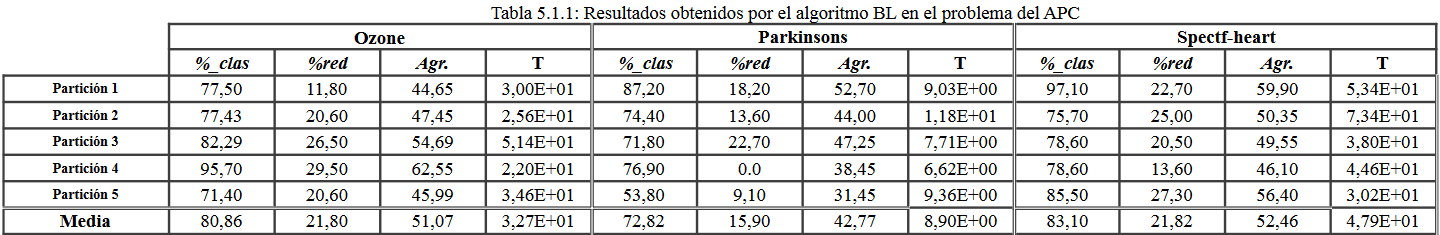

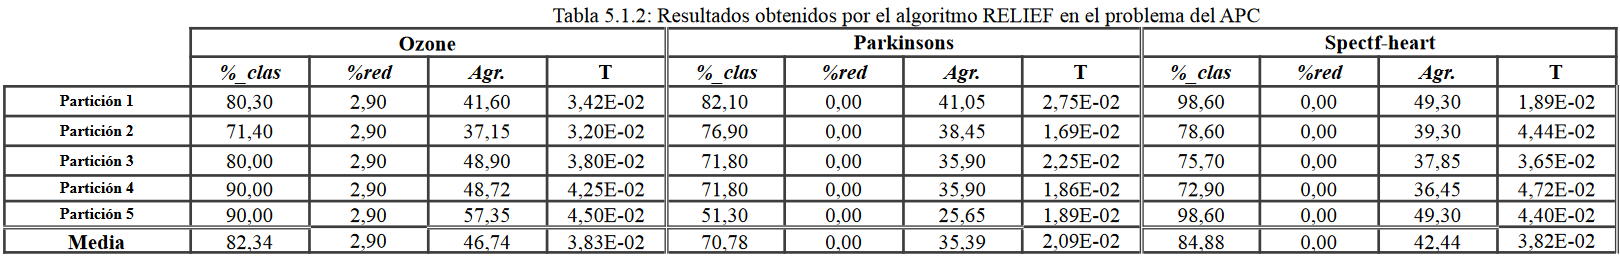

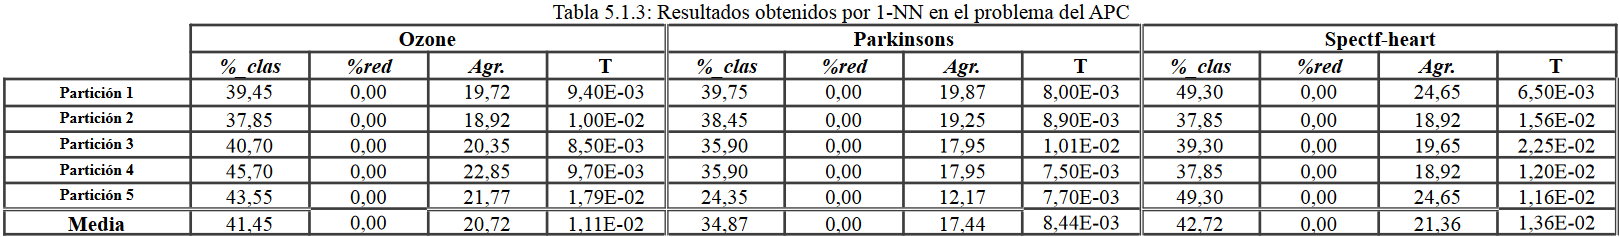

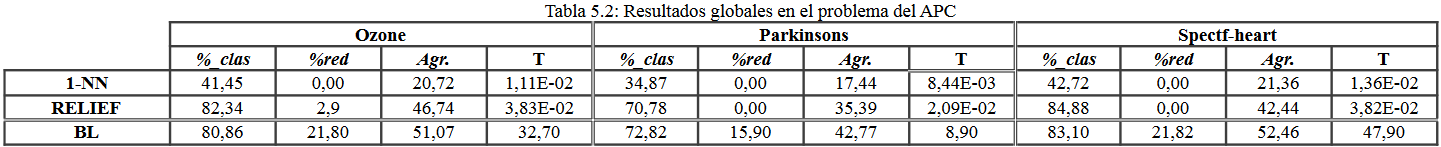

Como era de esperar, el 1-NN es el que obtiene los peores resultados con diferencia, tanto en % de clasificación como en agregación, aunque es evidentemente el más rápido en todos los casos porque es con diferencia el que menos cálculos tiene.<br>

En cuanto aal RELIEF y al BL, RELIEF obtiene ligeramente mejores resultados en ionosphere y spectf-heart mientras que BL lo hace en parkinsons.<br>

Donde sí destaca BL es en la agregación, donde obtiene mayores resultados. Es de esperar ya que la función de agregación se usa para evaluar la búsqueda local, así que este tiende a reducir atributos a 0 para maximizar la función objetivo.<br>

Vamos a observar cómo evoluciona el porcentaje de clasificación para una ejecución de parkinson. Para ello declararemos BL otra vez con un print que nos haga ver los valores cada vez que actualizamos $w$:

In [ ]:
def BL_search_2(datos, clases, max_iter):

  #Normalizar e inicializar w
  w_mejor = np.random.rand(len(datos[0]))
  w = w_mejor
  min_val, max_val = max_min_values(datos)
  datos = normaliza(datos, min_val, max_val-min_val)

  contador_greedy = 0
  i_w = 0
  iterations = 0
  fitness_actual = 0.0
  indx_w = np.arange(0, len(w))
  np.random.shuffle(indx_w)

  while(contador_greedy < len(w)*20 and iterations < max_iter):

    #Se calcula el fitness para w
    aciertos = calcular_error_leave(datos, clases, w)
    fitness = evaluacion(w, 0.5, aciertos)

    #Actualizar fitness y w si procede
    if (fitness > fitness_actual):
      print(np.around(aciertos*100, 2))
      fitness_actual = fitness
      w_mejor = w
      contador_greedy = 0
      i_w = 0
      np.random.shuffle(indx_w)
    else:
      contador_greedy += 1

    #Se calcula nuevo w + control de indices
    w = operador_mutacion(w, indx_w[i_w])
    iterations += 1
    i_w = (i_w+1)%len(w)

  return w, fitness_actual

np.random.seed(287364)
datos, clases = cargar_datos('/content/drive/MyDrive/MH/Instancias_APC/parkinsons.arff')
BL_search_2(datos, clases, 15000)

Si el profesor ha ejecutado el código anterior, podrá notar que el algoritmo empieza con un porcentaje de acierto del 95.38%, pero más adelante al actualizar el resultado, lo hace con una $w$ que da un porcentaje de clasificación menor. Esto lo hace porque la función objetivo, al valorar el número de atributos menores que 0.1, le compensa eliminar atributos aunque con ello baje el acierto. Esto podría arreglarse probando distintas ponderaciones para el parametro alpha de la función objetivo.<br>

Con esto ya nos queda algo más claro por qué RELIEF obtuvo mejores resultados en 2 datasets. Concluimos entonces que BL es un algoritmo que depende mucho del parámetro alpha (es decir, cuanto acierto está dispuesto a sacrificar para ganar en reducción de atributos), en el conjunto de datos sobre el que se ejecute y en la aleatoriedad de cada ejecución. En resumen, dependiendo del problema nos convendrá más usar uno u otro, la metaheurística empleada en la búsqueda local no siempre es mejor que el algoritmo de comparación. El 1NN, como era evidente, es el que peores resultados obtiene.